In [1]:
import backtrader as bt
import pandas as pd
import numpy as np
import random
import pytz
import time
import os
from xbbg import blp
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import interact, Dropdown, HBox, VBox, Button, Output, Text, widgets
import sympy as sp
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from IPython import get_ipython
import matplotlib.dates as mdates
from pydataquery import DataQuery
import re
import statsmodels.api as sm
from scipy.optimize import minimize
import scipy.stats as stats
import itertools
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
import yfinance as yf
import csv
import uuid
from concurrent.futures import ThreadPoolExecutor
import warnings
from multiprocess import Pool
import time
warnings.filterwarnings('ignore')

In [2]:
cdx_mult = 1.7

cdx = "CDX HY CDSI GEN 5Y SPRD CORP"
bond_etf = "HYG US EQUITY"
cdx_name = "CDX HY 5Y"
rates_etf = "USGG5YR INDEX"
rates_etf_name = "US 5Y"

cdx = "CDX IG CDSI GEN 5Y SPRD CORP"
bond_etf = "VCIT US EQUITY"
cdx_name = "CDX IG 5Y"
rates_etf = "USGG5YR INDEX"
rates_etf_name = "US 5Y"

cdx = "CDX EM CDSI GEN 5Y SPRD CORP"
bond_etf = "EMB US EQUITY"
cdx_name = "CDX EM 5Y"
rates_etf = "USGG7YR INDEX"
rates_etf_name = "US 7Y"

# cdx = "CDX IG CDSI GEN 10Y SPRD CORP"
# bond_etf = "LQD US EQUITY"
# cdx_name = "CDX IG 10Y"
# rates_etf = "USGG10YR INDEX"
# rates_etf_name = "US 10Y"

In [3]:


bond_etf_name = bond_etf.split(" ")[0]
all_basis_data = pd.read_excel("All Basis Data.xlsx",index_col=0, parse_dates=True)
px = all_basis_data[[cdx_name,bond_etf_name,rates_etf_name]].ffill().copy()

px_hist = blp.bdh(tickers=[cdx, bond_etf, rates_etf], flds="PX_LAST",start_date="2021-1-1")
daily = px_hist.dropna().copy()
daily.columns = [cdx_name, bond_etf_name,rates_etf_name]
daily.index.name = "Date"
daily = daily.reset_index()

dvd_hist = blp.bds(bond_etf, 'DVD_HIST_ALL', DVD_START_DT='20210101', DVD_END_DT='20251201' )
dvd = dvd_hist[["ex_date"]].reset_index().copy()
dvd.columns = ["Div","Date"]

comb = pd.merge(left=daily, right=dvd, on="Date", how="outer").set_index("Date").sort_index().copy()

dvd_dict = {}
dv = list(comb[f"Div"].dropna().index)

period_list = ["-3","-2","-1","+0","+1","+2","+3"]
shifted_indices = {}

for p in period_list:
    col_name = f"Div{p}"
    comb[col_name] = comb["Div"].shift(eval(p))
    key = f"p{p.replace('-','minus').replace('+','plus')}"
    shifted_indices[key] = list(comb[col_name].dropna().index)

dvd_dict = {}
for i, dv_item in enumerate(dv):
    dvd_dict[str(dv_item)] = [
        str(shifted_indices[f"p{p.replace('-','minus').replace('+','plus')}"][i])
        for p in period_list
        if i < len(shifted_indices[f"p{p.replace('-','minus').replace('+','plus')}"])
    ]

all_dates_list = []
for key, val in dvd_dict.items():
    all_dates_list += val

px = px[px.index.normalize().isin(all_dates_list)]
# px.to_excel(f"{cdx_name}_Raw.xlsx")




px = pd.read_excel(f"{cdx_name}_Raw.xlsx",index_col=0,parse_dates=True)
px["Basis"] = cdx_mult * px[cdx_name] - 100*(px[f'{bond_etf_name} Yld'] - px[rates_etf_name])
px = px[["Basis"]]
j=0
all_t = None
for key, val in dvd_dict.items():
    try:
        t1 = px[px.index.date == pd.to_datetime(val[0]).date()]
        t1.index = ["T-3 " + str(item).split(" ")[1] for item in t1.index]
        
        t2 = px[px.index.date == pd.to_datetime(val[1]).date()]
        t2.index = ["T-2 " + str(item).split(" ")[1] for item in t2.index]
        
        t3 = px[px.index.date == pd.to_datetime(val[2]).date()]
        t3.index = ["T-1 " + str(item).split(" ")[1] for item in t3.index]

        t3a = px[px.index.date == pd.to_datetime(val[3]).date()]
        t3a.index = ["T+0 " + str(item).split(" ")[1] for item in t3a.index]
        
        t4 = px[px.index.date == pd.to_datetime(val[4]).date()]
        t4.index = ["T+1 " + str(item).split(" ")[1] for item in t4.index]
        
        t5 = px[px.index.date == pd.to_datetime(val[5]).date()]
        t5.index = ["T+2 " + str(item).split(" ")[1] for item in t5.index]
    
        t6 = px[px.index.date == pd.to_datetime(val[6]).date()]
        t6.index = ["T+3 " + str(item).split(" ")[1] for item in t6.index]
    
        t = pd.concat([t1,t2,t3,t3a,t4,t5,t6])
        t.columns = [key]
        all_t = pd.concat([all_t, t],axis=1)
    except:
        h=1
all_t = all_t.dropna(how="all",axis=1).copy()

ty = all_t.copy()
ty["Key"] = [item.split(" ")[0] for item in ty.index]
ty["Key2"] = [pd.to_datetime(item.split(" ")[1]).time() for item in ty.index]
order = ["T-3", "T-2", "T-1", "T+0", "T+1", "T+2", "T+3"]
order_map = {k: i for i, k in enumerate(order)}
ty = ty.sort_values(by=["Key", "Key2"], key=lambda col: col.map(order_map) if col.name == "Key" else col).drop(["Key2"],axis=1)

all_y = None
for item in order:
    x = ty[ty["Key"]==item].drop(["Key"],axis=1).iloc[:,-12:]
    x = x - x.iloc[0]
    
    y = ty[ty["Key"]==item].drop(["Key"],axis=1)#.iloc[:,-12:]
    y = (y - y.iloc[0]).iloc[[-1]].T
    all_y = pd.concat([all_y, y],axis=1)
    # break
    # x.plot(figsize=(12,4))
    # plt.axhline(0, color="black",linewidth=3)
    # plt.title(f"{cdx_name} Basis move on {item}")
    # plt.legend(loc="lower left")
    # plt.show()
all_data = pd.DataFrame(all_y.mean())
all_data.index.name = cdx_name + " Basis"
all_data.columns = ["Mean"]
all_data["Median"] = all_y.median()
all_data["All Data Points"] = [np.nan] * len(all_data)
all_data["Positive Basis Move Data Points"] = [np.nan] * len(all_data)
all_data["Avg. Positive Basis Move"] = [np.nan] * len(all_data)
all_data["Median Positive Basis Move"] = [np.nan] * len(all_data)
all_data["Negative Basis Move Data Points"] = [np.nan] * len(all_data)
all_data["Median Negative Basis Move"] = [np.nan] * len(all_data)

for col in all_y.columns:
# col = all_y.columns[0]
    z = list(all_y[col].dropna())
    pos = [item for item in z if item>0]
    neg = [item for item in z if item<0]
    
    all_data.loc[col, "All Data Points"] = len(z)
    all_data.loc[col, "Positive Basis Move Data Points"] = len(pos)
    all_data.loc[col, "Avg. Positive Basis Move"] = np.mean(pos)
    all_data.loc[col, "Median Positive Basis Move"] = np.median(pos)
    
    all_data.loc[col, "Negative Basis Move Data Points"] = len(neg)
    all_data.loc[col, "Avg. Negative Basis Move"] = np.mean(neg)
    all_data.loc[col, "Median Negative Basis Move"] = np.median(neg)
    
all_data["% Positive Basis Move"] = all_data["Positive Basis Move Data Points"]*100/all_data["All Data Points"]
all_data["% Negative Basis Move"] = all_data["Negative Basis Move Data Points"]*100/all_data["All Data Points"]
all_data = all_data[["Mean","Median","% Positive Basis Move","Avg. Positive Basis Move","Median Positive Basis Move",\
    "% Negative Basis Move","Avg. Negative Basis Move","Median Negative Basis Move"]]
all_data = round(all_data,2)
all_data

,Mean,Median,% Positive Basis Move,Avg. Positive Basis Move,Median Positive Basis Move,% Negative Basis Move,Avg. Negative Basis Move,Median Negative Basis Move
CDX EM 5Y Basis,,,,,,,,
T-3 15:55:00,-1.47,-0.37,41.82,2.08,1.33,58.18,-4.02,-1.83
T-2 15:55:00,0.57,0.02,50.00,3.13,2.35,50.00,-1.99,-1.38
T-1 15:55:00,-1.39,-0.84,43.64,2.33,2.07,56.36,-4.27,-3.30
T+0 15:55:00,0.29,0.04,50.91,3.69,2.40,49.09,-3.24,-2.42
T+1 15:55:00,0.79,0.60,62.50,2.68,1.74,37.50,-2.38,-1.67
T+2 15:55:00,-0.62,-0.95,44.44,2.53,2.19,55.56,-3.14,-3.18
T+3 15:55:00,-0.28,-0.05,46.43,3.05,2.11,53.57,-3.16,-2.81


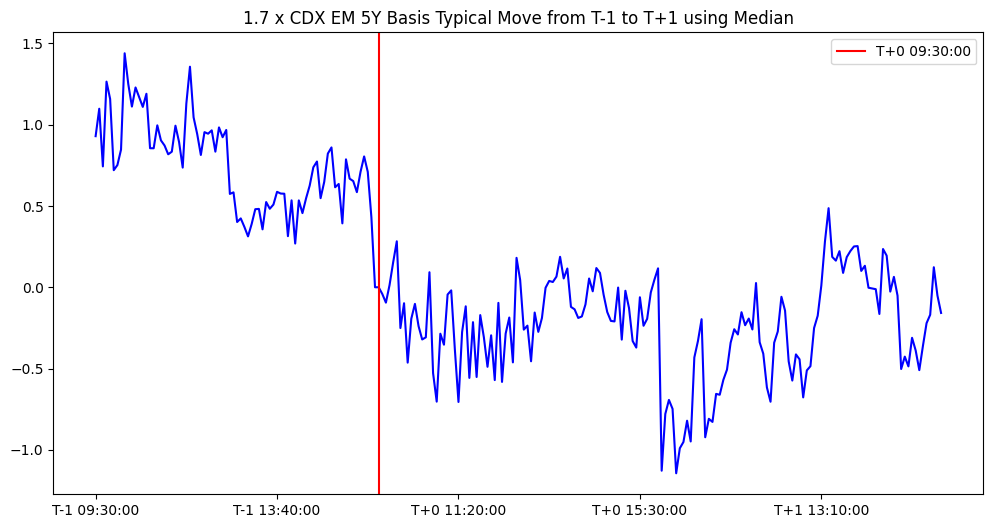

In [11]:
df_plot = ty[ty["Key"].isin(["T-1","T+0","T+1"])].copy()
# df_plot = ty.copy()
na = df_plot.isna().sum()
df_plot = df_plot.drop(list(na[na!=0].index)+["Key"],axis=1)
# df_plot1 = df_plot.iloc[:78,:]
df_plot1 = df_plot.loc[:"T-1 15:55:00",:]
df_plot2 = df_plot.loc["T+0 09:30:00":,:]
df_plot1 = df_plot1 - df_plot1.iloc[-1]
df_plot2 = df_plot2 - df_plot2.iloc[0]
df_plot3 = pd.concat([df_plot1, df_plot2])

s = df_plot3.median(axis=1)
ax = s.plot(figsize=(12,6),color="blue")

# xpos = s.index.get_loc("T+0 09:30:00")
# ax.axvline(xpos, color="red",label="T+0 09:30:00")

# xpos = s.index.get_loc("T+0 10:20:00")
# ax.axvline(xpos, color="black",label="Min. Value at T+0 10:20:00")

# xpos = s.index.get_loc("T+1 14:40:00")
# ax.axvline(xpos, color="green",label="Max. Value at T+1 14:40:00")

# time_labels = [
#     "T-3 09:30:00", "T-2 09:30:00", "T-1 09:30:00",
#     "T+0 09:30:00", "T+1 09:30:00", "T+2 09:30:00", "T+3 09:30:00"
# ]

# for label in time_labels:
#     xpos = s.index.get_loc(label)
#     ax.axvline(x=xpos, label=label)

time_labels = [
    "T-3 09:30:00", "T-2 09:30:00", "T-1 09:30:00",
    "T+0 09:30:00", "T+1 09:30:00", "T+2 09:30:00", "T+3 09:30:00"]
colors = ["blue", "green", "orange", "red", "purple", "brown", "black"]
for label, color in zip(time_labels, colors):
    xpos = s.index.get_loc(label)
    ax.axvline(x=xpos, color=color, label=label)
    
plt.title(f"{cdx_mult} x {cdx_name} Basis Typical Move from T-1 to T+1 using Median")
plt.legend()
plt.show()

In [5]:
s1 = s[:78]
s1[s1==np.max(s1)]

T-1 09:50:00    1.793356
dtype: float64

In [6]:
s2 = s[78:78*2]
s2[s2==np.min(s2)]

T+0 10:55:00   -0.638569
dtype: float64

In [7]:
1.793356+0.638569

2.431925

In [8]:
s2[s2==np.max(s2)]

T+0 14:35:00    0.652229
dtype: float64

In [10]:
0.638569+0.652229

1.2907980000000001